# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [45]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [46]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [47]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [48]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        # Перший шар, який складається з 128 нейронів
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        # Другий шар, який складається з 256 нейронів
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        # Вихідний шар
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        # Передача даних через перший два шари та вихідний шар з функцією активації softmax
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x, activation=1)
        return x
    

In [49]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))


def accuracy(y_pred, y_true):
    y_true = tf.cast(y_true, tf.int64)

    if len(y_true.shape) > 1:
        y_true = tf.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:
        y_pred = tf.argmax(y_pred, axis=1)

    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [50]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі


def train(neural_net, input_x, output_y):
    optimizer = tf.optimizers.SGD(learning_rate)

    with tf.GradientTape() as g:
        pred = neural_net(input_x)
        loss = cross_entropy(pred, output_y)

    gradients = g.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))
    return loss


In [51]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    loss = train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)
        print(f"Step {step}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")
        

Step 100, Loss: 324.4420, Accuracy: 0.6797
Step 200, Loss: 290.5273, Accuracy: 0.7305
Step 300, Loss: 214.9857, Accuracy: 0.7852
Step 400, Loss: 190.2776, Accuracy: 0.7852
Step 500, Loss: 109.3619, Accuracy: 0.8672
Step 600, Loss: 180.5452, Accuracy: 0.7891
Step 700, Loss: 118.8000, Accuracy: 0.8672
Step 800, Loss: 110.3184, Accuracy: 0.8945
Step 900, Loss: 133.4150, Accuracy: 0.8789
Step 1000, Loss: 137.8906, Accuracy: 0.8789
Step 1100, Loss: 114.7414, Accuracy: 0.8906
Step 1200, Loss: 115.7531, Accuracy: 0.8984
Step 1300, Loss: 93.6954, Accuracy: 0.9023
Step 1400, Loss: 70.3341, Accuracy: 0.9297
Step 1500, Loss: 100.4555, Accuracy: 0.8984
Step 1600, Loss: 134.0958, Accuracy: 0.8711
Step 1700, Loss: 75.7884, Accuracy: 0.9336
Step 1800, Loss: 123.0782, Accuracy: 0.8789
Step 1900, Loss: 57.7446, Accuracy: 0.9336
Step 2000, Loss: 86.9105, Accuracy: 0.9062
Step 2100, Loss: 65.3762, Accuracy: 0.9297
Step 2200, Loss: 61.3842, Accuracy: 0.9336
Step 2300, Loss: 82.0774, Accuracy: 0.9102
Step 

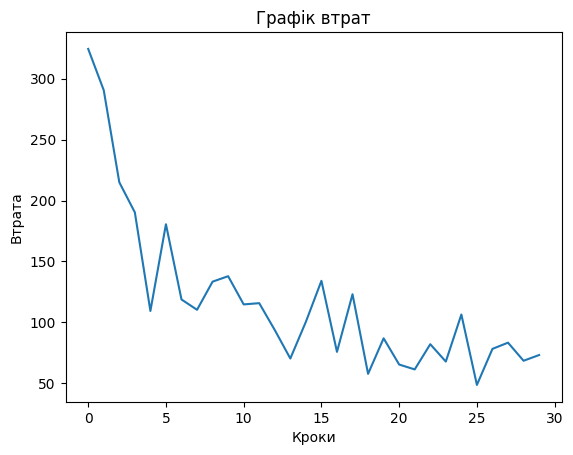

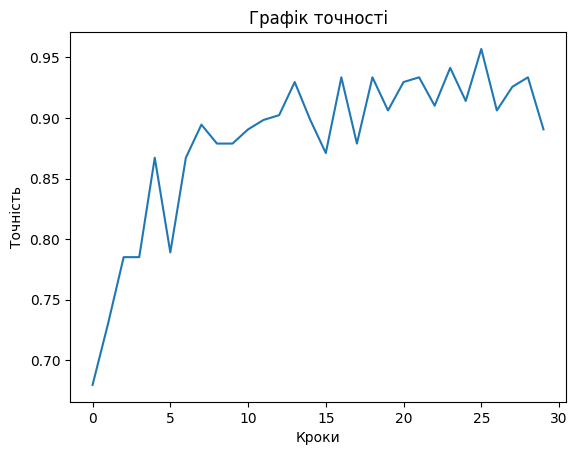

In [52]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.plot(loss_history)
plt.title("Графік втрат")
plt.xlabel("Кроки")
plt.ylabel("Втрата")
plt.show()

# Виведіть графік точності
plt.plot(accuracy_history)
plt.title("Графік точності")
plt.xlabel("Кроки")
plt.ylabel("Точність")
plt.show()


In [53]:
from sklearn.metrics import classification_report

# Отримання передбачень на тестових даних
pred_test = neural_net(x_test)

# Обчислення точності
test_accuracy = accuracy(pred_test, y_test)
print(f"Точність на тестових даних: {test_accuracy:.4f}")

# Перевірка форми y_test та pred_test
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of pred_test: {pred_test.shape}")

# Викликаємо tf.argmax тільки для pred_test, оскільки y_test вже містить індекси класів
y_true = y_test  # y_test вже містить правильні класи, немає потреби в tf.argmax
# Використовуємо tf.argmax для передбачень
y_pred = tf.argmax(pred_test, axis=1).numpy()

# Перевірка форми після argmax
print(f"Shape after argmax, y_true: {y_true.shape}, y_pred: {y_pred.shape}")
print(f"y_true: {y_true[:10]}")  # Виведення перших 10 значень для перевірки
print(f"y_pred: {y_pred[:10]}")  # Виведення перших 10 значень для перевірки

# Виведення метрик якості для кожного класу
print(classification_report(y_true, y_pred))

Точність на тестових даних: 0.9035
Shape of y_test: (10000,)
Shape of pred_test: (10000, 10)
Shape after argmax, y_true: (10000,), y_pred: (10000,)
y_true: [7 2 1 0 4 1 4 9 5 9]
y_pred: [7 2 1 0 4 1 9 7 5 9]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       980
           1       0.97      0.97      0.97      1135
           2       0.88      0.89      0.89      1032
           3       0.88      0.88      0.88      1010
           4       0.91      0.91      0.91       982
           5       0.85      0.86      0.86       892
           6       0.93      0.92      0.93       958
           7       0.92      0.90      0.91      1028
           8       0.86      0.85      0.86       974
           9       0.88      0.88      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



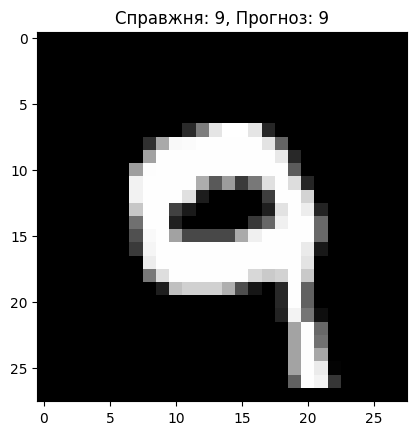

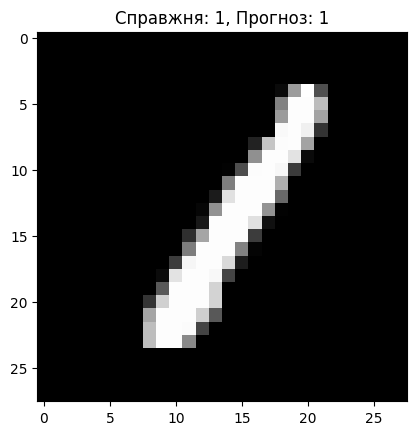

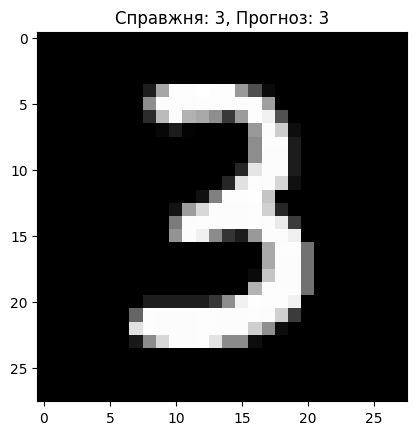

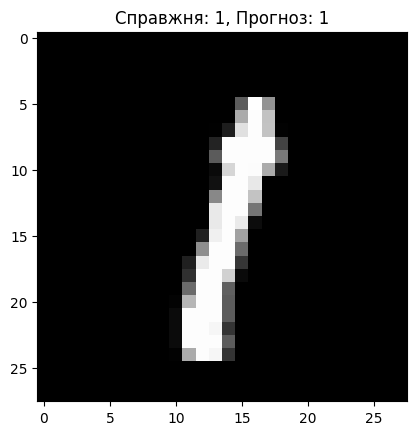

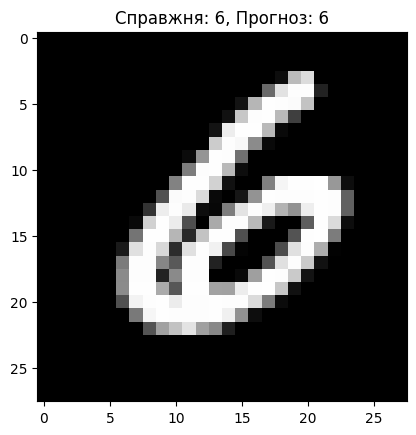

In [55]:
import random
import matplotlib.pyplot as plt

for i in range(5):
    idx = random.randint(0, len(x_test) - 1)

    img = x_test[idx].reshape((28, 28))

    label = y_test[idx]

    pred = neural_net(x_test[idx:idx+1])
    predicted_label = tf.argmax(pred, axis=1).numpy()

    plt.imshow(img, cmap='gray')
    plt.title(f"Справжня: {label}, Прогноз: {predicted_label[0]}")
    plt.show()